In [3]:
#Compares UFO and sunspot observations over time
import numpy as np
import pandas as pd
from scipy import signal
import statsmodels.tsa.stattools
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-darkgrid')

In [4]:
# load UFO data
ufo_data = pd.read_csv('scrubbed.csv', usecols=[0, 4, 5], low_memory=False)
ufo_data['datetime'] = pd.to_datetime(ufo_data['datetime'], errors='coerce')

In [9]:
# load sunspot data M
s2 = pd.read_csv('data_sunspots.csv')
s2['datetime'] = pd.to_datetime((s2.YEAR*10000+s2.MONTH*100+1).apply(str),format='%Y%m%d')

In [10]:
# load sunspot data
sunspots = pd.read_csv('data_sunspots.csv', usecols=[0, 1, 2, 5])# http://sidc.oma.be/silso/newdataset 
sunspots['datetime'] = pd.to_datetime((sunspots.YEAR*10000+sunspots.MONTH*100+sunspots.DAY).apply(str),format='%Y%m%d')

In [11]:
# Format and group sunspot data by month
df2 = sunspots  
df2 = df2[(df2['datetime'] > '1997-03-30') & (df2['datetime'] <= '2012-12-31')]
df2m = df2.set_index('datetime').groupby(pd.TimeGrouper('1M')).mean()

In [12]:
# Format and group UFO rows by month
df1 = ufo_data
df1 = df1[(df1['datetime'] > '1997-03-30') & (df1['datetime'] <= '2012-12-31')]
df1m = df1.set_index('datetime').groupby(pd.TimeGrouper('1M')).agg(['count'])

In [13]:
# # Add month index to join on
df1m['YEAR'] = df2m['YEAR']
df1m['MONTH'] = df2m['MONTH']

In [14]:
# Merge UFO and sunspot data
merged = pd.merge(df2m,df1m, on=['YEAR','MONTH'], left_index=True)
idx = merged.index

/Users/amandaparker/anaconda/lib/python2.7/site-packages/pandas/tools/merge.py:536: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [15]:
#merged

In [16]:
Y1 = merged['shape', 'count']
Y2 = merged.Nb # observation count
#Y2 = merged.Snvalue # use total sunspot count

In [17]:
# Normalise to min/max
Y1n = (Y1-min(Y1))/(max(Y1)-min(Y1))
Y2n = (Y2-min(Y2))/(max(Y2)-min(Y2))

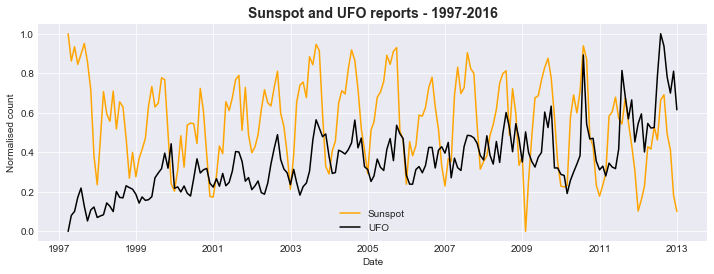

In [18]:
# Draw plot
plt.figure(figsize=(12,4))
plt.plot(Y2n,color='orange',alpha=1, label='Sunspot')
plt.plot(Y1n,color='k', label='UFO')
plt.title('Sunspot and UFO reports - 1997-2016', fontsize=14, fontweight='bold')
plt.ylabel('Normalised count')
plt.xlabel('Date')
plt.legend(loc='lower center')
plt.savefig('./imgs/UFOsunspots_1997-2016.png')
plt.show()

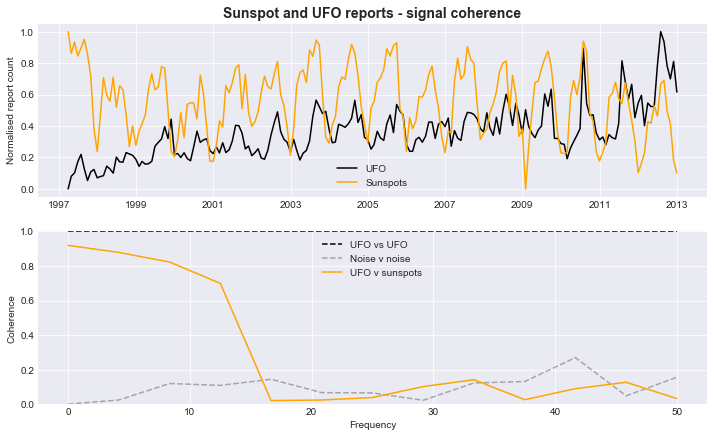

In [19]:
# UFO - test signal coherence with sunspot counts
nfft = 24
dt = 0.01
n = 1./dt
plt.figure(figsize=(12,7))
plt.subplot(211)
plt.title('Sunspot and UFO reports - signal coherence', fontsize=14, fontweight='bold')
plt.plot(Y1n,'k',label="UFO")
plt.plot(Y2n,color='orange',label="Sunspots")
plt.ylabel('Normalised report count')
plt.legend(loc='lower center')
plt.subplot(212)
cxy, f = plt.cohere(Y1n, Y1n, nfft,n , color='k', alpha=1, linestyle='--', label='UFO vs UFO')
cxy, f = plt.cohere(np.random.randn(len(Y1)), np.random.randn(len(Y1)), nfft,n , color='k', alpha=.3, linestyle='--', label='Noise v noise')
cxy, f = plt.cohere(Y1n, Y2n, nfft, n, color='orange', alpha=1, label='UFO v sunspots')
plt.ylabel('Coherence')
plt.legend(loc='upper center')
plt.ylim(0,1)
plt.savefig('./imgs/UFOsunspots_freqCoherence.png')
plt.show()

In [25]:
# Granger test for Y1 x Y2
sig_noise = Y1 + np.random.randn(len(Y1))
x1 = pd.DataFrame([Y1,Y2])
x1 = x1.transpose().copy()
x2 = pd.DataFrame([Y1,sig_noise])
x2 = x2.transpose().copy()
x3 = pd.DataFrame([np.random.randn(len(Y1)),np.random.randn(len(Y1))])
x3 = x3.transpose().copy()
maxlag = 24
gr1 = statsmodels.tsa.stattools.grangercausalitytests(x1, maxlag, verbose=False)
gr2 = statsmodels.tsa.stattools.grangercausalitytests(x2, maxlag, verbose=False)
gr3 = statsmodels.tsa.stattools.grangercausalitytests(x3, maxlag, verbose=False)

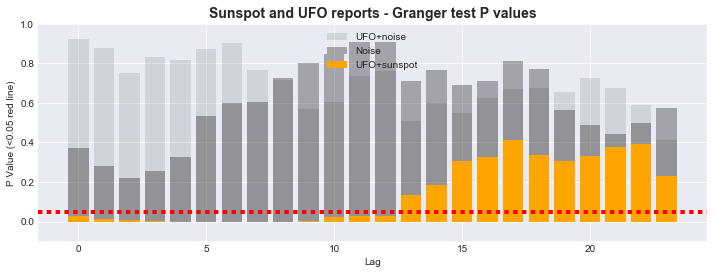

In [26]:
#Plot the granger p values 
resd1 = {}
for i in range(0,maxlag):
    resd1[i] = gr1[i+1][0]['params_ftest'][1]  
resd2 = {}
for i in range(0,maxlag):
    resd2[i] = gr2[i+1][0]['params_ftest'][1]  
resd3 = {}
for i in range(0,maxlag):
    resd3[i] = gr3[i+1][0]['params_ftest'][1]   
pvals1 = pd.Series(resd1)
pvals2 = pd.Series(resd2)
pvals3 = pd.Series(resd3)
plt.figure(figsize=(12,4))
plt.ylim(-0.1,1)
plt.bar(pvals2.index,pvals2,color='k',alpha=.1, label='UFO+noise')
plt.bar(pvals3.index,pvals3,color='k',alpha=.3, label="Noise")
plt.bar(pvals1.index,pvals1, color='orange', label='UFO+sunspot')
plt.axhline(0.05, ls=':', c='r', linewidth=4)
plt.legend(loc='upper center')
plt.title('Sunspot and UFO reports - Granger test P values', fontsize=14, fontweight='bold')
plt.xlabel('Lag')
plt.ylabel('P Value (<0.05 red line)')
plt.savefig('./imgs/UFOsunspots_granger_pvals.png')

In [27]:
# Time series decomposition 
dta = Y1
# deal with missing values. see issue
dta.interpolate(inplace=True)
res = sm.tsa.seasonal_decompose(dta)
# graph = res.plot()
# graph.suptitle('UFO reports - time series decomposition', fontsize=14, fontweight='bold')
# graph.set_size_inches(10,8)

/Users/amandaparker/anaconda/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


In [28]:
dta = Y2
# deal with missing values. see issue
dta.interpolate(inplace=True)
res2 = sm.tsa.seasonal_decompose(dta)
# graph = res2.plot()
# graph.suptitle('Sunspot reports - time series decomposition', fontsize=14, fontweight='bold')
# graph.set_size_inches(10,8)

In [29]:
# Get decomposed time series
# res.resid
# res.seasonal
# res.trend
Y1res = res.resid
Y1sea = res.seasonal
Y1tre = res.trend
Y2res = res2.resid
Y2sea = res2.seasonal
Y2tre = res2.trend

Y1res.dropna(inplace="fill")
Y1sea.dropna(inplace="fill")
Y1tre.dropna(inplace="fill")
Y2res.dropna(inplace="fill")
Y2sea.dropna(inplace="fill")
Y2tre.dropna(inplace="fill")

In [30]:
# Normalise to min/max
Y1resN = (Y1res-min(Y1res))/(max(Y1res)-min(Y1res))
Y2resN = (Y2res-min(Y2res))/(max(Y2res)-min(Y2res))
Y1seaN = (Y1sea-min(Y1sea))/(max(Y1sea)-min(Y1sea))
Y2seaN = (Y2sea-min(Y2sea))/(max(Y2sea)-min(Y2sea))
Y1treN = (Y1tre-min(Y1tre))/(max(Y1tre)-min(Y1tre))
Y2treN = (Y2tre-min(Y2tre))/(max(Y2tre)-min(Y2tre))

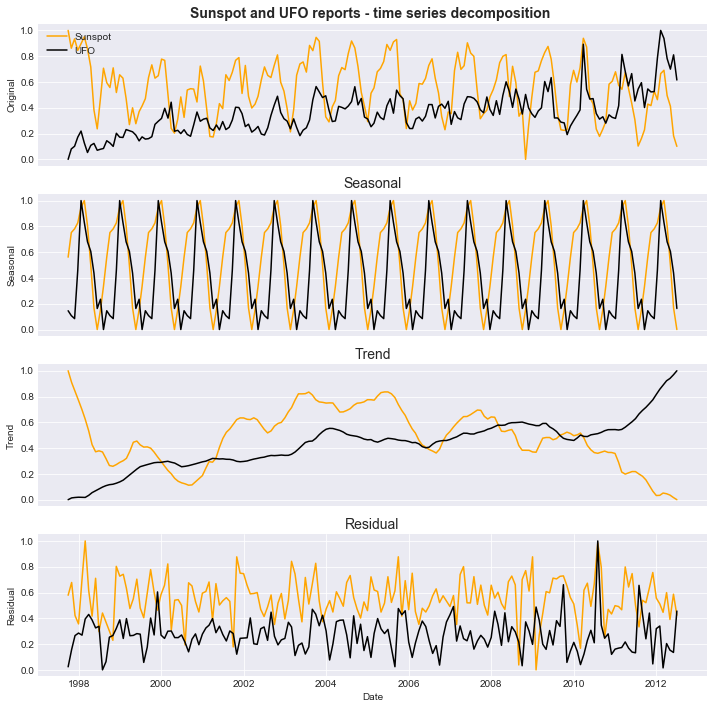

In [31]:
# Is it the same seasonal cycle?
# Draw plot
plt.figure(figsize=(12,12))

plt.subplot(411)
plt.title('Sunspot and UFO reports - time series decomposition ', fontsize=14, fontweight='bold')
plt.plot(Y2n,color='orange',alpha=1, label='Sunspot')
plt.plot(Y1n,color='k', label='UFO')
plt.ylabel('Original')
#plt.xlabel('Date')
plt.legend(loc='upper left')
plt.xticks([])

plt.subplot(412)
plt.plot(Y2seaN,color='orange',alpha=1, label='Sunspot')
plt.plot(Y1seaN,color='k', label='UFO')
plt.title('Seasonal', fontsize=14)
plt.ylabel('Seasonal')
#plt.xlabel('Date')
#plt.legend(loc='upper left')
plt.xticks([])

plt.subplot(413)
plt.plot(Y2treN,color='orange',alpha=1, label='Sunspot')
plt.plot(Y1treN,color='k', label='UFO')
plt.title('Trend', fontsize=14)
plt.ylabel('Trend')
#plt.xlabel('Date')
#plt.legend(loc='upper left')
plt.xticks([])

plt.subplot(414)
plt.plot(Y2resN,color='orange',alpha=1, label='Sunspot')
plt.plot(Y1resN,color='k', label='UFO')
plt.title('Residual', fontsize=14)
plt.ylabel('Residual')
plt.xlabel('Date')
#plt.legend(loc='upper left')

plt.savefig('./imgs/UFOsunspots_timeseries.png')
plt.show()

In [32]:
# remove seasonal, look at trend+residual 
t1 = (Y1treN * Y1resN)
p1 = (t1*1)/max(t1)
t2 = (Y2treN * Y2resN)
p2 = (t2*1)/max(t2)

In [33]:
# Granger test for decomposed data
x1 = pd.DataFrame([p1,p2])
x1 = x1.transpose()
x2 = pd.DataFrame([Y1resN,Y1resN])
x2 = x2.transpose()
x3 = pd.DataFrame([np.random.randn(len(p1)),np.random.randn(len(p1))])
x3 = x3.transpose()

In [34]:
maxlag = 24 #12 for seaonal
gr1 = statsmodels.tsa.stattools.grangercausalitytests(x1, maxlag, verbose=False)
gr2 = statsmodels.tsa.stattools.grangercausalitytests(x2, maxlag, verbose=False)
gr3 = statsmodels.tsa.stattools.grangercausalitytests(x3, maxlag, verbose=False)

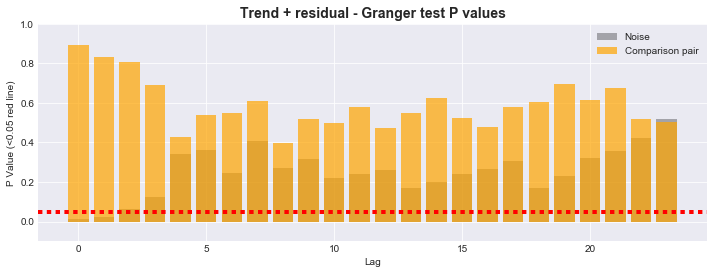

In [35]:
#Plot the granger p values 
resd1 = {}
for i in range(0,maxlag):
    resd1[i] = gr1[i+1][0]['params_ftest'][1]  
resd2 = {}
for i in range(0,maxlag):
    resd2[i] = gr2[i+1][0]['params_ftest'][1]  
resd3 = {}
for i in range(0,maxlag):
    resd3[i] = gr3[i+1][0]['params_ftest'][1]   
pvals1 = pd.Series(resd1)
pvals2 = pd.Series(resd2)
pvals3 = pd.Series(resd3)
plt.figure(figsize=(12,4))
plt.ylim(-0.1,1)

#plt.bar(pvals2.index,pvals2,color='k',alpha=.1, label='UFO+noise')
plt.bar(pvals3.index,pvals3,color='k',alpha=.3, label="Noise")
plt.bar(pvals1.index,pvals1, color='orange',alpha=.7, label='Comparison pair')
plt.axhline(0.05, ls=':', c='r', linewidth=4)
plt.legend(loc='upper right')
plt.title('Trend + residual - Granger test P values', fontsize=14, fontweight='bold')
plt.xlabel('Lag')
plt.ylabel('P Value (<0.05 red line)')
plt.savefig('./imgs/UFOsunspots_granger_pvals_seasonal_removed.png')